<a href="https://colab.research.google.com/github/frapasti/Embedded-Person-detection/blob/main/Scale_Stat_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STATISTICS OVER DIVVERENT SCALES
This notebook aims to evaluate the performances of some off the shelf person detectors with metrics such as precision, recall, miss rate and f1 score over different input scales.

First of all, install the needed libraries

In [ ]:
!pip install fiftyone --no-binary fiftyone,voxel51-eta
import fiftyone as fo
import fiftyone.zoo as foz
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import json
import cv2
import imutils
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import load_img
import fiftyone.zoo as foz
from fiftyone import ViewField as F
import os

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

# Dataset downloads
In order to evaluate over different scales the input images must start from the same size.
The chosen size is 640x480.
The dataset is downloaded with the fiftyone tool for coco-2017

In [3]:
#DATASET containing persons
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=["person"],
    only_matching = True,
    max_samples=1000,
)

 100% |██████|    1.9Gb/1.9Gb [2.8s elapsed, 0s remaining, 695.0Mb/s]       
Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'
 100% |████████████████| 1000/1000 [1.5m elapsed, 0s remaining, 11.5 images/s]      
Writing annotations for 1000 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'validation'
 100% |███████████████| 1000/1000 [5.0s elapsed, 0s remaining, 206.4 samples/s]      
Dataset 'coco-2017-validation-1000' created


In [5]:
f = open('/root/fiftyone/coco-2017/validation/labels.json')
data = json.load(f)
annotations = data['annotations']
every_path = []
cols = 10
rows = 1000
bbox_size = 4
counters = [0] * rows
bboxes = [[] for i in range(rows)] 
items = 0
# Creation of the list of paths of images in the dataset and bboxes
# This elements are extracted from the json file downloaded from coco with the dataset
for entry in data['annotations']:
    class_id = entry['category_id']
    if (class_id == 1):
        img_id = entry['image_id']
        path = float(img_id)/pow(10,11)
        dec_path = format(path, '.11f')
        final_path = ''
        final_path = '/root/fiftyone/coco-2017/validation/data/'+ dec_path.replace('.', '') + '.jpg'
        if(every_path.count(final_path) == 0):
          every_path.append(final_path)
          bboxes[items].append(entry['bbox'])
          items = items + 1
        else:
          index = every_path.index(final_path)
          if(counters[index] + 1 < 10):
            bboxes[index].append(entry['bbox'])
            counters[index] = counters[index] + 1

# Matain only images of size 640x480
f_every_path = []
f_bboxes = []
for i in range(0, len(every_path)):
  original_img = load_img(every_path[i])
  width, height = original_img.size
  if(width == 640 and height == 480):
    f_every_path.append(every_path[i])
    f_bboxes.append(bboxes[i])

assert(len(bboxes)==len(every_path))

In [6]:
#DATASET of non persons
dataset1 = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["detections"],
    only_matching = True,
    max_samples=500,
)

class_name = "Person"

# Find samples that have a "Person"
pos_view = dataset1.filter_labels("ground_truth", F("label")==class_name)

# Find all samples without a positively labeled "Person"
neg_view = dataset1.exclude(pos_view)

# Tag any samples that have a person in the App with "remove"
session = fo.launch_app(view=neg_view)

Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'
 100% |██████████████████| 500/500 [42.4s elapsed, 0s remaining, 10.8 images/s]      
Writing annotations for 500 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'train'
 100% |█████████████████| 500/500 [3.5s elapsed, 0s remaining, 146.2 samples/s]      
Dataset 'coco-2017-train-500' created


In [7]:
# Find and remove all tagged samples from the DatasetView
neg_view = neg_view.match_tags("remove", bool=False)

neg_view.export(
    export_dir="/content/nonPerson1",
    dataset_type=fo.types.COCODetectionDataset,
)

# Mantain only images of size 640x480
non_persons = listdir_fullpath("/content/nonPerson1/data")
for i in range(0, len(non_persons)):
  original_img = load_img(non_persons[i])
  width, height = original_img.size
  if(width == 640 and height == 480):
    f_every_path.append(non_persons[i])
    f_bboxes.append([])

print("The notebook is valuating performances over " + len(f_every_path) + " images of size 640x480 containing zero or more persons")

 100% |█████████████████| 243/243 [1.2s elapsed, 0s remaining, 209.6 samples/s]         


# Helper functions

In [9]:
def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox[0] , gt_bbox[1], gt_bbox[0] + gt_bbox[2] , gt_bbox[1] + gt_bbox[3]
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox[0] , pred_bbox[1], pred_bbox[0] + pred_bbox[2] , pred_bbox[1] + pred_bbox[3]
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [10]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xlest, yleft, width, height]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    
    if len(gt_boxes)==0:
        tp=0
        fp=len(pred_boxes)
        fn=0
        return [tp, fp, fn]
    
    if len(pred_boxes)==0 & len(gt_boxes) != 0:
        tp=0
        fp=0
        fn=len(gt_boxes)
        return [tp, fp, fn]

    if len(pred_boxes)==0 & len(gt_boxes) == 0:
        tp=0
        fp=0
        fn=len(gt_boxes)
        return [tp, fp, fn]
    
    tp = 0
    for i in range(0, len(gt_boxes)):
      for h in range(0, len(pred_boxes)):
        if(calc_iou(gt_boxes[i],pred_boxes[h]) >= iou_thr):
          if(tp < len(pred_boxes)):
            tp += 1
            break
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    return [tp, fp, fn]

# HOG EVALUATION

Get some statistics like precision,recall... by scaling down the original scale of the image to 1.0,0.9,0.8...
Compare the results with the ground truth bounding boxes that have also been scaled down by the same scale factor

In [26]:
def hog_detector(im_path, scale): 
  # Initializing the HOG person
  # detector
  hog = cv2.HOGDescriptor()
  hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    
  # Reading the Image
  image = cv2.imread(im_path)
  cv2.resize(image,(int(640*scale),int(480*scale)))
    
  # Detecting all the regions in the 
  # Image that has a pedestrians inside it
  (regions, _) = hog.detectMultiScale(image, 
                                      winStride=(4, 4),
                                      padding=(4, 4),
                                      scale=1.05)

  return regions

**N.B.** The next cell infers a huge number of images len(every_path)*10 so it may take a long time to fully process the data. Last execution took 29 min!

In [73]:
scale = 1.0
regions = []  #proposed regions
scaled_bboxes = [] #scaled down version of ground truth boxes
for i in range(0,10):
  temp_regions = []
  temp_boxes = []
  for h in range(0,len(f_every_path)): #for every image
    prop_regions = hog_detector(f_every_path[h], scale) #get proposed_regions at current scale
    temp_regions.append(prop_regions)
    temp_boxes_in = []
    for x,y,w,h in f_bboxes[h]:
      temp_boxes_in.append([x * scale, y * scale, w * scale, h * scale])
    temp_boxes.append(temp_boxes_in)
  regions.append(temp_regions)
  scaled_bboxes.append(temp_boxes)
  scale = scale - 0.1

In [74]:
hog_results = np.zeros((10,3))
HOG_precision = np.zeros((10,))
HOG_recall = np.zeros((10,))
HOG_f1 = np.zeros((10,))
HOG_missrate = np.zeros((10,))
scales = []
scale = 1.0
for h in range(0,10):
  scales.append(scale)
  tp = 0
  fp = 0
  fn = 0 
  for i in range(0, 268):
    res = get_single_image_results(scaled_bboxes[h][i],regions[h][i],0.1)
    tp += res[0]
    fp += res[1]
    fn += res[2]
    hog_results[h][0] = tp
    hog_results[h][1] = fp
    hog_results[h][2] = fn
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    HOG_precision[h] = tp / (tp + fp)
    HOG_recall[h] = tp / (tp + fn)
    if(prec + rec != 0):
      HOG_f1[h] = 2 * (prec * rec)/ (prec + rec)
    HOG_missrate[h] = fn / (tp + fn) 
  scale = scale - 0.1

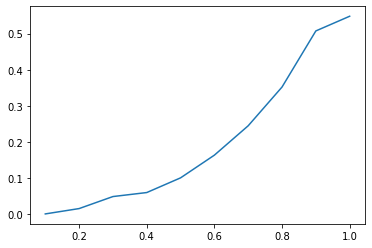

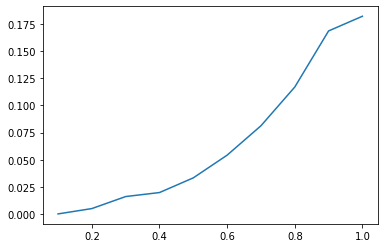

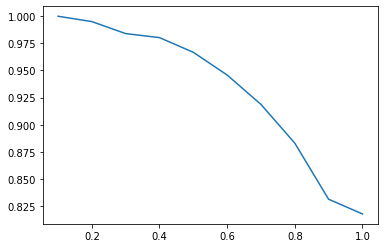

In [76]:
pyplot.plot(scales, HOG_precision)
pyplot.show()

pyplot.plot(scales, HOG_recall)
pyplot.show()

pyplot.plot(scales, HOG_missrate)
pyplot.show()

from scipy.io import savemat

mdic = {"scales": scales}
savemat("/content/HOG_results/iou_thresholds.mat", mdic)

mdic = {"HOG_precision": HOG_precision}
savemat("/content/HOG_results/HOG_precision.mat", mdic)

mdic = {"HOG_recall": HOG_recall}
savemat("/content/HOG_results/HOG_recall.mat", mdic)

mdic = {"HOG_missrate": HOG_missrate}
savemat("/content/HOG_results/HOG_missrate.mat", mdic)

mdic = {"HOG_f1": HOG_f1}
savemat("/content/HOG_results/HOG_f1.mat", mdic)

# VIOLA results

In [77]:
def viola_detector(im_path, scale): 
    
  #Reading the Image
  image = cv2.imread(im_path)

  cv2.resize(image,(int(640*scale),int(480*scale)))
  #convert in gray_scale since the cascade classifier works on gray_scale images
  grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #load the cascade classifier, detect the bodies in the image and draw them for the user to see
  body_cascade = cv2.CascadeClassifier('/content/haarcascade_fullbody.xml')
  detected_bodies = body_cascade.detectMultiScale(grayscale_image)
      
  return detected_bodies

In [78]:
scale = 1.0
viola_regions = []  #proposed regions
for i in range(0,10):
  temp_regions = []
  for h in range(0,len(f_every_path)): #for every image
    prop_regions = viola_detector(f_every_path[h], scale) #get proposed_regions at current scale
    temp_regions.append(prop_regions)
  viola_regions.append(temp_regions)
  scale = scale - 0.1

In [79]:
viola_results = np.zeros((10,3))
viola_precision = np.zeros((10,))
viola_recall = np.zeros((10,))
viola_f1 = np.zeros((10,))
viola_missrate = np.zeros((10,))
for h in range(0,10):
  tp = 0
  fp = 0
  fn = 0 
  for i in range(0, 268):
    res = get_single_image_results(scaled_bboxes[h][i],viola_regions[h][i],0.1)
    tp += res[0]
    fp += res[1]
    fn += res[2]
  viola_results[h][0] = tp
  viola_results[h][1] = fp
  viola_results[h][2] = fn
  prec = tp / (tp + fp)
  rec = tp / (tp + fn)
  viola_precision[h] = tp / (tp + fp)
  viola_recall[h] = tp / (tp + fn)
  if(prec + rec != 0):
    viola_f1[h] = 2 * (prec * rec)/ (prec + rec)
  viola_missrate[h] = fn / (tp + fn) 

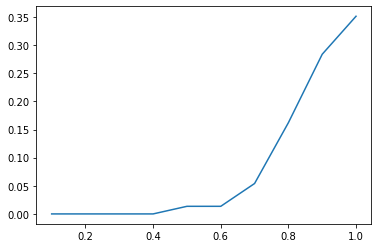

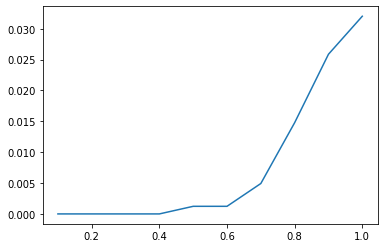

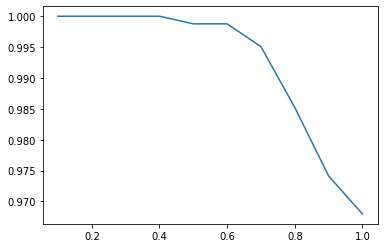

In [80]:
pyplot.plot(scales, viola_precision)
pyplot.show()

pyplot.plot(scales, viola_recall)
pyplot.show()

pyplot.plot(scales, viola_missrate)
pyplot.show()

from scipy.io import savemat

mdic = {"viola_precision": viola_precision}
savemat("/content/VIOLA_results/viola_precision.mat", mdic)

mdic = {"viola_recall": viola_recall}
savemat("/content/VIOLA_results/viola_recall.mat", mdic)

mdic = {"viola_missrate": viola_missrate}
savemat("/content/VIOLA_results/viola_missrate.mat", mdic)

mdic = {"viola_f1": viola_f1}
savemat("/content/VIOLA_results/viola_f1.mat", mdic)

# IMPROVED VIOLA

In [81]:
def viola_detector_powered(im_path, scale): 
    
  #Reading the Image
  image = cv2.imread(im_path)
  
  cv2.resize(image,(int(640*scale),int(480*scale)))
  #convert in gray_scale since the cascade classifier works on gray_scale images
  grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #load the cascade classifier, detect the bodies in the image and draw them for the user to see
  body_cascade = cv2.CascadeClassifier('/content/haarcascade_fullbody.xml')
  lbody_cascade = cv2.CascadeClassifier('/content/haarcascade_lowerbody.xml') #lower body
  ubody_cascade = cv2.CascadeClassifier('/content/haarcascade_upperbody.xml') #upper body
  
  detected_bodies = body_cascade.detectMultiScale(grayscale_image)
  ldetected_bodies = lbody_cascade.detectMultiScale(grayscale_image) #lower_body
  udetected_bodies = ubody_cascade.detectMultiScale(grayscale_image) #upper_body
  
  tot_bodies = list(detected_bodies) + list(ldetected_bodies) + list(udetected_bodies) #concatenate all the detected bboxes

  return tot_bodies

In [82]:
scale = 1.0
pow_viola_regions = []  #proposed regions
for i in range(0,10):
  temp_regions = []
  for h in range(0,len(f_every_path)): #for every image
    prop_regions = viola_detector_powered(f_every_path[h], scale) #get proposed_regions at current scale
    temp_regions.append(prop_regions)
  pow_viola_regions.append(temp_regions)
  scale = scale - 0.1

In [84]:
pow_viola_results = np.zeros((10,3))
pow_viola_precision = np.zeros((10,))
pow_viola_recall = np.zeros((10,))
pow_viola_f1 = np.zeros((10,))
pow_viola_missrate = np.zeros((10,))
for h in range(0,10):
  tp = 0
  fp = 0
  fn = 0 
  for i in range(0, 268):
    res = get_single_image_results(scaled_bboxes[h][i],pow_viola_regions[h][i],0.1)
    tp += res[0]
    fp += res[1]
    fn += res[2]
  pow_viola_results[h][0] = tp
  pow_viola_results[h][1] = fp
  pow_viola_results[h][2] = fn
  prec = tp / (tp + fp)
  rec = tp / (tp + fn)
  pow_viola_precision[h] = tp / (tp + fp)
  pow_viola_recall[h] = tp / (tp + fn)
  if(prec + rec != 0):
    pow_viola_f1[h] = 2 * (prec * rec)/ (prec + rec)
  pow_viola_missrate[h] = fn / (tp + fn)

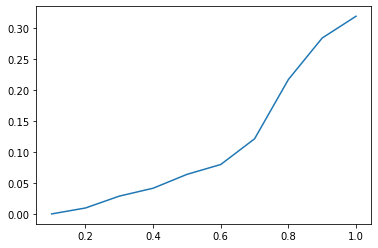

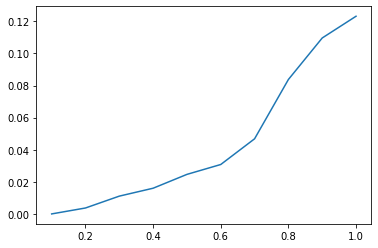

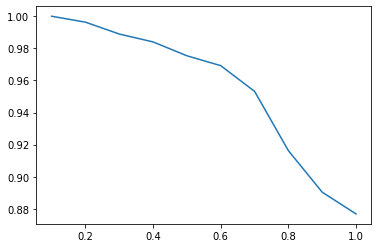

In [85]:
pyplot.plot(scales, pow_viola_precision)
pyplot.show()

pyplot.plot(scales, pow_viola_recall)
pyplot.show()

pyplot.plot(scales, pow_viola_missrate)
pyplot.show()

from scipy.io import savemat

mdic = {"pow_viola_precision": pow_viola_precision}
savemat("/content/pow_VIOLA_results/pow_viola_precision.mat", mdic)

mdic = {"pow_viola_recall": pow_viola_recall}
savemat("/content/pow_VIOLA_results/pow_viola_recall.mat", mdic)

mdic = {"pow_viola_missrate": pow_viola_missrate}
savemat("/content/pow_VIOLA_results/pow_viola_missrate.mat", mdic)

mdic = {"pow_viola_f1": pow_viola_f1}
savemat("/content/pow_VIOLA_results/pow_viola_f1.mat", mdic)